# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>

### <font color=blue><div align="center">29-02-2024</div></font>

## Modules

In [9]:
# Basic modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Gurobi module
from gurobipy import *

## Data Extraction

In [10]:
number_of_seats = 174
weight_f = 70
weight_m = 85
weight_d = 92.5
number_of_rows = 29
number_of_columns = 6

In [11]:
# Load the Excel file into a pandas DataFrame
df = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=0 , skipfooter=2)

In [12]:
# Display the DataFrame
df

,Numéro du groupe,Femmes,Hommes,WCHR,TransitTime
0,1,NaN,1.0,NaN,01:15:00
1,2,1.0,NaN,NaN,00:00:00
2,3,NaN,1.0,NaN,00:00:00
3,4,1.0,NaN,NaN,00:00:00
4,5,NaN,2.0,NaN,05:25:00
...,...,...,...,...,...
106,107,1.0,NaN,NaN,03:30:00
107,108,2.0,NaN,NaN,05:25:00
108,109,2.0,NaN,NaN,05:25:00
109,110,2.0,NaN,NaN,01:35:00


In [56]:

Passagers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0
transit_times= set()
for group in df.itertuples():
    for j in range(2,5):
        if not pd.isna(group[j]):
            for k in range(int(group[j])):
                Passagers[i] = {'gender': j-2, 'group':group[1], 'transit': float('inf') }
                if group[5].hour*60 + group[5].minute != 0:
                    Passagers[i]['transit'] = group[5].hour*60 + group[5].minute
                    transit_times.add(group[5].hour*60 + group[5].minute)
                if j == 2: number_f+=1
                elif j==3: number_m+=1
                else: number_d+=1

                i+=1    
Passagers

{1: {'gender': 1, 'group': 1, 'transit': 75},
 2: {'gender': 0, 'group': 2, 'transit': inf},
 3: {'gender': 1, 'group': 3, 'transit': inf},
 4: {'gender': 0, 'group': 4, 'transit': inf},
 5: {'gender': 1, 'group': 5, 'transit': 325},
 6: {'gender': 1, 'group': 5, 'transit': 325},
 7: {'gender': 0, 'group': 6, 'transit': inf},
 8: {'gender': 0, 'group': 7, 'transit': 190},
 9: {'gender': 0, 'group': 8, 'transit': 80},
 10: {'gender': 1, 'group': 8, 'transit': 80},
 11: {'gender': 1, 'group': 9, 'transit': 140},
 12: {'gender': 0, 'group': 10, 'transit': inf},
 13: {'gender': 0, 'group': 11, 'transit': 235},
 14: {'gender': 1, 'group': 11, 'transit': 235},
 15: {'gender': 1, 'group': 12, 'transit': 70},
 16: {'gender': 1, 'group': 13, 'transit': inf},
 17: {'gender': 0, 'group': 14, 'transit': inf},
 18: {'gender': 1, 'group': 14, 'transit': inf},
 19: {'gender': 1, 'group': 15, 'transit': 360},
 20: {'gender': 1, 'group': 16, 'transit': 95},
 21: {'gender': 0, 'group': 17, 'transit': 60

In [14]:
Groups = dict()

for i, passager in Passagers.items():

    if passager['group'] in Groups:
        Groups[passager['group']].append(i)
    else :
        Groups[passager['group']] = [i]

Groups

{1: [1],
 2: [2],
 3: [3],
 4: [4],
 5: [5, 6],
 6: [7],
 7: [8],
 8: [9, 10],
 9: [11],
 10: [12],
 11: [13, 14],
 12: [15],
 13: [16],
 14: [17, 18],
 15: [19],
 16: [20],
 17: [21, 22],
 18: [23],
 19: [24, 25, 26, 27],
 20: [28, 29, 30, 31],
 21: [32, 33],
 22: [34],
 23: [35, 36],
 24: [37, 38],
 25: [39],
 26: [40],
 27: [41, 42],
 28: [43],
 29: [44],
 30: [45],
 31: [46, 47],
 32: [48],
 33: [49],
 34: [50, 51],
 35: [52, 53],
 36: [54],
 37: [55],
 38: [56],
 39: [57, 58],
 40: [59],
 41: [60],
 42: [61],
 43: [62],
 44: [63],
 45: [64, 65],
 46: [66],
 47: [67],
 48: [68],
 49: [69],
 50: [70],
 51: [71, 72],
 52: [73],
 53: [74],
 54: [75],
 55: [76, 77],
 56: [78, 79],
 57: [80, 81],
 58: [82],
 59: [83, 84],
 60: [85],
 61: [86, 87],
 62: [88],
 63: [89, 90],
 64: [91],
 65: [92, 93, 94],
 66: [95],
 67: [96],
 68: [97, 98],
 69: [99],
 70: [100],
 71: [101, 102],
 72: [103],
 73: [104],
 74: [105],
 75: [106],
 76: [107],
 77: [108, 109],
 78: [110],
 79: [111],
 80: [112

## Model

Defining the relevant variables of the problem

In [15]:

m = Model("Seats_Allocation")

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k}') for i in range(1, number_of_rows + 1) for j in range(1, number_of_columns + 1) for k in range(1, len(Passagers)+1)}

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-04


The constraints

- Every person has a seat

In [16]:
SEATSASSIGNMENTCONST = m.addConstr(quicksum([AssignmenVarDict[(i, j, k)] for i in range(1, number_of_rows + 1) for j in range(1, number_of_columns + 1) for k in range(1,len(Passagers)+1)]) == len(Passagers))


- Every person has one seat

In [17]:
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)] for i in range(1, number_of_rows + 1) for j in range(1, number_of_columns + 1) ]) == 1) for k in range(1,len(Passagers)+1) }

- Every seat is allocated to a single person

In [18]:
ALLOCATIONCONSTDIC = { (i,j) : m.addConstr(quicksum([AssignmenVarDict[(i,j,k)] for k in range(1, len(Passagers)+1)])<=1) for i in range(1, number_of_rows + 1) for j in range(1, number_of_columns+1)  }

- Barycenter constraint

In [19]:

i_m = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)] for i in range(1, number_of_rows+1) for j in range(1, number_of_columns+1 ) for k in range(1, len(Passagers)+1) if Passagers[k]['gender']==1])
i_f = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)] for i in range(1, number_of_rows+1) for j in range(1, number_of_columns+1 ) for k in range(1, len(Passagers)+1) if Passagers[k]['gender']==0])
i_d = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)] for i in range(1, number_of_rows+1) for j in range(1, number_of_columns+1 ) for k in range(1, len(Passagers)+1) if Passagers[k]['gender']==2])

i_bary = (i_m + i_f +i_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

j_m = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)] for i in range(1, number_of_rows+1) for j in range(1, number_of_columns+1 ) for k in range(1, len(Passagers)+1) if Passagers[k]['gender']==1])
j_f = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)] for i in range(1, number_of_rows+1) for j in range(1, number_of_columns+1 ) for k in range(1, len(Passagers)+1) if Passagers[k]['gender']==0])
j_d = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)] for i in range(1, number_of_rows+1) for j in range(1, number_of_columns+1 ) for k in range(1, len(Passagers)+1) if Passagers[k]['gender']==2])

j_bary = (j_m + j_f + j_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

In [20]:
IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 4)
JMINBARYCONST = m.addConstr(3 <= j_bary )

- A disabeled person has 4 seats on the aisle side

In [ ]:
## TO DO

## Objectif

- Transit time

In [21]:
grouping = quicksum( [ AssignmenVarDict[(i,j,k)]* i*(1/Passagers[k]['transit']) for i in range(1, number_of_rows+1) for j in range(1, number_of_columns+1 ) for k in range(1, len(Passagers)+1) if Passagers[k]['transit'] != float('inf') ])

m.setObjective(grouping, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()

- Grouping

In [ ]:
## TO DO

## Optimisation

In [22]:

m.optimize()


if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tN'THERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()

                                                   z* = 5.68                                                    



In [59]:
def generate_red_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
        # Calculate the intensity of red from 0 to 255
        red_intensity = int(255 * i / (num_gradations - 1))
        # Format the color value as hexadecimal
        color_value = "#{:02X}0000".format(red_intensity)
        gradations.append(color_value)
    return gradations
graduation = generate_red_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()

In [60]:
transit_times

[45,
 50,
 60,
 65,
 70,
 75,
 80,
 90,
 95,
 100,
 120,
 135,
 140,
 190,
 210,
 235,
 325,
 360]

In [61]:
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[i]

In [66]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [['#000000' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [['#000000' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passagers[k]['transit']]
                else:
                    data2[i-1][j-4] = k
                    if Passagers[k]['transit']!=float('inf'): colors2[i-1][j-4] = color_transit[Passagers[k]['transit']]

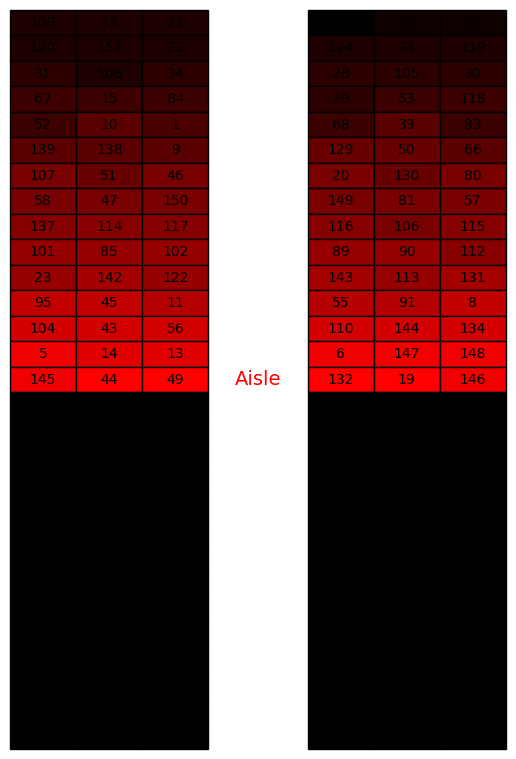

In [67]:

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)

plt.subplots_adjust(wspace=0.5)

plt.show()